In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import feather
import gc
from datetime import datetime
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import scipy
from sklearn.metrics import roc_auc_score
from numba import jit

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
%%time

optimizedDataTypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float32',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float32',
        'AVProductsEnabled':                                    'float32',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float32',
        'GeoNameIdentifier':                                    'float32',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float32',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float32',
        'IeVerIdentifier':                                      'float32',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float32',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float32',
        'Census_ProcessorManufacturerIdentifier':               'float32',
        'Census_ProcessorModelIdentifier':                      'float32',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float32',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float32',
        'Census_IsFlightsDisabled':                             'float32',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float32',
        'Census_FirmwareManufacturerIdentifier':                'float32',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float32',
        'Census_IsVirtualDevice':                               'float32',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float32',
        'Wdft_IsGamer':                                         'float32',
        'Wdft_RegionIdentifier':                                'float32',
        'HasDetections':                                        'int8'
}


trainData =pd.read_feather('train.ft')


#time of importing both datasets has reduced dramatically.

Wall time: 22.6 s


In [3]:
%%time
trainData = trainData.astype(optimizedDataTypes)



Wall time: 1min 14s


In [4]:
%%time
#print (train.head(1))
trainLabel = trainData['HasDetections']
trainID = trainData['MachineIdentifier']
trainData=trainData.drop(['MachineIdentifier'], inplace=False, axis=1)


Wall time: 4.47 s
Parser   : 140 ms


In [5]:
##Block to play with df.isnan, df.isnan.sum , df.isnan.count
# data = [['tom', 10], [np.NaN, 15], [np.NaN, np.NaN]] 
  
# # Create the pandas DataFrame 
# df = pd.DataFrame(data, columns = ['Name', 'Age'])
# df.sort_values(by='Age' , ascending=False)

# print ( df.count() )

In [5]:
%%time
n=len(trainID)
print (n,len(trainLabel))
print (sum(trainID.isna()),sum(trainLabel.isna()))

#verifying if we have equal number of machine IDs and labels and they don't have any missing values.

8921483 8921483
0 0
Wall time: 4.41 s


In [6]:
%%time
no_missing = (trainData.isnull().sum())
na_percent = ((no_missing/n).sort_values(ascending=False))

# plt.bar(na_percent.keys,na_percent.values)

#percentage of missing values in each column.

# temp = (train.isnull().sum().count())
# print (temp)

Wall time: 11.5 s


In [24]:
new = na_percent.to_numpy()

Text(-183.375, 0.5, 'Column names')

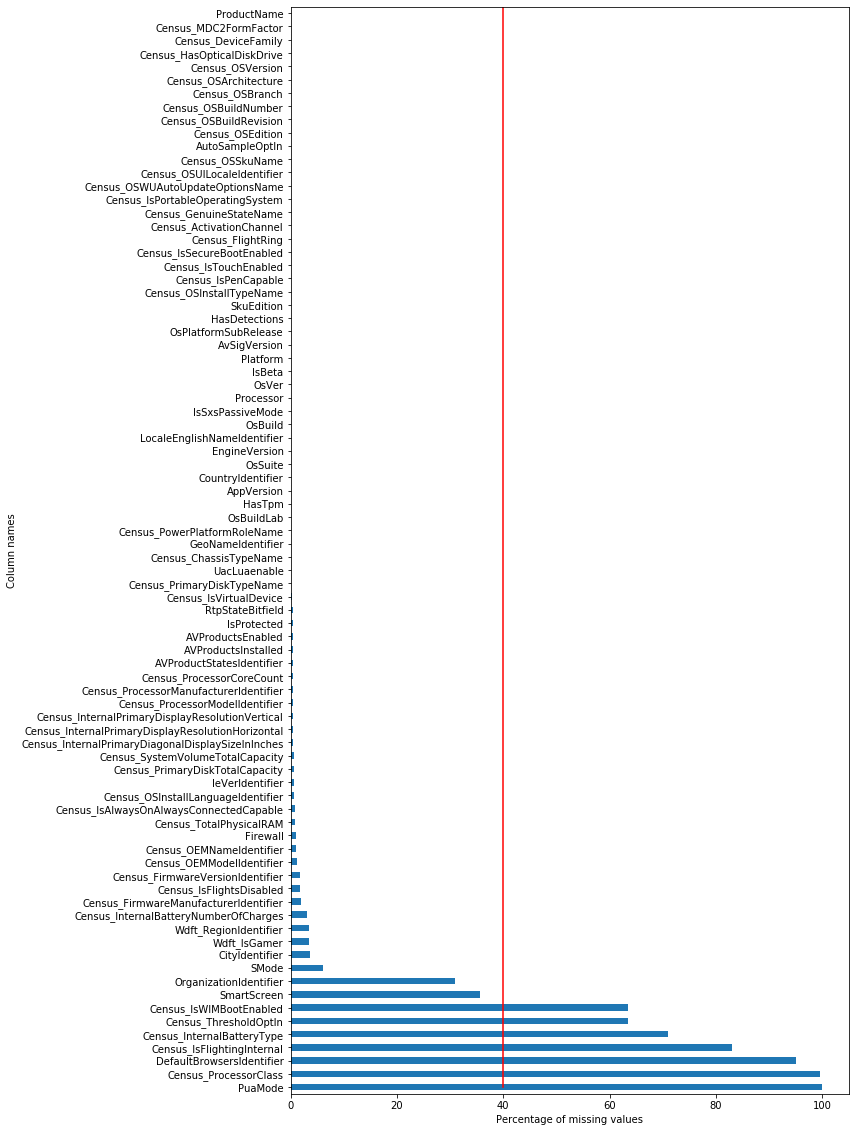

In [10]:
fig = plt.figure(figsize=(10,20))
na_percent=na_percent/100
na_percent.T.plot(kind='barh')
plt.plot(np.array([40]*50),np.linspace(0,200),color='red')
plt.savefig('missing_graph.png')
plt.xlabel('Percentage of missing values')
plt.ylabel('Column names')

Colname - SmartScreen - Data Cleaning

In [8]:
%%time
print((trainData['SmartScreen']).unique())

#since there are categpries that just have their cases changed ex: RequireAdmin and requireAdmin

trainData['SmartScreen'] = trainData['SmartScreen'].str.lower()
print((trainData['SmartScreen']).nunique())

#we now have 14 categories which were 21 earlier.

trainData['SmartScreen']=trainData['SmartScreen'].replace(
    {'promt': 'prompt', 
    'promprt': 'prompt',
    'enabled': 'on',
    'of': 'off',
    'deny': '0',
    '00000000': '0',
    'requiredadmin': 'requireadmin'},inplace=False)
print((trainData['SmartScreen']).nunique())

#we now have 11 categories. 

#since promt, promprt and prompt are same. requiredadmin is same as requireadmin. of and off are similar.
#deny and 0000000 represent NaN values, which have been replaced by 0 now and would be replaced by
#NaN.


trainData['SmartScreen'] = trainData['SmartScreen'].replace({'0': np.nan}, inplace=False)
print((trainData['SmartScreen']).nunique())

#we now have 10 categories.

trainData['SmartScreen']=trainData['SmartScreen'].astype('category')

# ^^optimizing data frame be defining optmized data type.

[NaN, RequireAdmin, ExistsNotSet, Off, Warn, ..., prompt, warn, 00000000, requireAdmin, &#x03;]
Length: 22
Categories (21, object): [RequireAdmin, ExistsNotSet, Off, Warn, ..., warn, 00000000, requireAdmin, &#x03;]
14
11
10
Wall time: 3.65 s


Colname - Census_InternalBatteryType - Developing numerical feature

In [10]:
%%time
print((trainData['Census_InternalBatteryType']).unique())
print((trainData['Census_InternalBatteryType']).nunique())

#we currently have 78 categories as of now however, mostly all categories represent specificity of 
#the battery but batteries can be easily categorized in just 2 categories i.e. Li battery or ~Li battery

trainData['li'] = trainData['Census_InternalBatteryType'].str.lower()
newColumn=[]
looplist = trainData['li'].iteritems()
for c in looplist:
    if ('li' in c):
        newColumn.append(1)
    else:
        newColumn.append(0)
newDf = pd.DataFrame({'li' : newColumn})
trainData.update(newDf)
#^^ new levels that are 0 and 1 have been added to data frame.

trainData['li'] = trainData['li'].astype('uint8')
#optimizing data type

print((trainData['li']).unique())
print((trainData['li']).nunique())
        



[NaN, lion, li-i, #, lip, ..., 8, #TAB#, l&#TAB#, liÿÿ, lÿÿÿ]
Length: 79
Categories (78, object): [lion, li-i, #, lip, ..., #TAB#, l&#TAB#, liÿÿ, lÿÿÿ]
78
[0 1]
2
Wall time: 33.2 s


In [12]:
%%time
del newColumn
del c
del looplist
#^^free up useless variables. [Save as much RAM as possible, you'll need it]

Wall time: 122 ms


Checking all columns - Data Cleaning

In [13]:
%%time
looplist = trainData.columns
# print (looplist)

for c in looplist:
    print (c)
    print (trainData[c].unique()[:10])
    print (trainData[c].nunique())

#^^to verify no other column requires cleaning (apart from removing NaNs)    
del looplist
del c


ProductName
[win8defender, mse, mseprerelease, windowsintune, fep, scep]
Categories (6, object): [win8defender, mse, mseprerelease, windowsintune, fep, scep]
6
EngineVersion
[1.1.15100.1, 1.1.14600.4, 1.1.15200.1, 1.1.15300.6, 1.1.13504.0, 1.1.14800.3, 1.1.15000.2, 1.1.14104.0, 1.1.13804.0, 1.1.14306.0]
Categories (70, object): [1.1.15100.1, 1.1.14600.4, 1.1.15200.1, 1.1.15300.6, ..., 1.1.11202.0, 1.1.11104.0, 1.1.12802.0, 1.1.10701.0]
70
AppVersion
[4.18.1807.18075, 4.13.17134.1, 4.9.218.0, 4.18.1806.18062, 4.18.1809.2, 4.10.209.0, 4.8.10240.17914, 4.13.17134.228, 4.12.16299.15, 4.14.17639.18041]
Categories (110, object): [4.18.1807.18075, 4.13.17134.1, 4.9.218.0, 4.18.1806.18062, ..., 4.13.17618.1000, 4.12.16299.0, 4.8.10240.17943, 4.13.17604.1000]
110
AvSigVersion
[1.273.1735.0, 1.263.48.0, 1.273.1341.0, 1.273.1527.0, 1.273.1379.0, 1.273.1094.0, 1.273.845.0, 1.273.1393.0, 1.275.988.0, 1.273.973.0]
Categories (8531, object): [1.273.1735.0, 1.263.48.0, 1.273.1341.0, 1.273.1527.0, ...,

Categories (30, object): [PROFESSIONAL, CORE, CORE_SINGLELANGUAGE, ENTERPRISE_S, ..., STARTER, PRO_FOR_EDUCATION, PRO_SINGLE_LANGUAGE, UNDEFINED]
30
Census_OSInstallTypeName
[UUPUpgrade, IBSClean, Update, Upgrade, Other, Clean, Reset, Refresh, CleanPCRefresh]
Categories (9, object): [UUPUpgrade, IBSClean, Update, Upgrade, ..., Clean, Reset, Refresh, CleanPCRefresh]
9
Census_OSInstallLanguageIdentifier
[26.  8.  7. 17. 18. 14. 27.  6. 29. 37.]
39
Census_OSUILocaleIdentifier
[119  31  30  64  72  49 120  28 125 158]
147
Census_OSWUAutoUpdateOptionsName
[UNKNOWN, FullAuto, Notify, AutoInstallAndRebootAtMaintenanceTime, Off, DownloadNotify]
Categories (6, object): [UNKNOWN, FullAuto, Notify, AutoInstallAndRebootAtMaintenanceTime, Off, DownloadNotify]
6
Census_IsPortableOperatingSystem
[0 1]
2
Census_GenuineStateName
[IS_GENUINE, OFFLINE, INVALID_LICENSE, UNKNOWN, TAMPERED]
Categories (5, object): [IS_GENUINE, OFFLINE, INVALID_LICENSE, UNKNOWN, TAMPERED]
5
Census_ActivationChannel
[Retail, 

Data Imputation - Didn't follow blog. We can use that if accuracy isn't >= 50% for any model.

In [14]:
%%time
colnames=trainData.columns
train_nona  = trainData.dropna(axis=0 , inplace= False)
print(len(train_nona))
print(len(test_nona))

# ^^ The plan was to merge rows from train and test data with no NaN values and then train 
# regression models on this merged set to predict feature values on the missing columns.


NameError: name 'testData' is not defined

In [15]:
%%time
imputer = SimpleImputer(strategy='median')

trainData['Census_InternalBatteryNumberOfCharges'] = imputer.fit_transform(trainData['Census_InternalBatteryNumberOfCharges'].values.reshape(-1,1))

trainData['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = imputer.fit_transform(trainData['Census_InternalPrimaryDiagonalDisplaySizeInInches'].values.reshape(-1,1))

trainData['Census_ProcessorCoreCount'] = imputer.fit_transform(trainData['Census_ProcessorCoreCount'].values.reshape(-1,1))

trainData['Census_TotalPhysicalRAM'] = imputer.fit_transform(trainData['Census_TotalPhysicalRAM'].values.reshape(-1,1))

trainData['Census_PrimaryDiskTotalCapacity'] = imputer.fit_transform(trainData['Census_PrimaryDiskTotalCapacity'].values.reshape(-1,1))

trainData['Census_SystemVolumeTotalCapacity'] = imputer.fit_transform(trainData['Census_SystemVolumeTotalCapacity'].values.reshape(-1,1))

trainData['Census_InternalPrimaryDisplayResolutionHorizontal'] = imputer.fit_transform(trainData['Census_InternalPrimaryDisplayResolutionHorizontal'].values.reshape(-1,1))

trainData['Census_InternalPrimaryDisplayResolutionVertical'] = imputer.fit_transform(trainData['Census_InternalPrimaryDisplayResolutionVertical'].values.reshape(-1,1))

trainData['AVProductsEnabled'] = imputer.fit_transform(trainData['AVProductsEnabled'].values.reshape(-1,1))

trainData['AVProductsInstalled'] = imputer.fit_transform(trainData['AVProductsInstalled'].values.reshape(-1,1))


Wall time: 11.2 s


In [16]:
%%time
# total disk capacity remaining
trainData['disk_space_remain'] = trainData['Census_PrimaryDiskTotalCapacity'] - trainData['Census_SystemVolumeTotalCapacity']

trainData['disk_space_remain'] = trainData['disk_space_remain'].astype('float32')


# Ram-to-CPU ratio
trainData['ram_to_cpu_ratio'] = trainData['Census_TotalPhysicalRAM'] / 
                                                                    trainData['Census_ProcessorCoreCount']


# Pixel Per Inch PPI sqrt(horizonal**2 + vertical**2) / diagonal
trainData['ppi'] = np.sqrt(trainData['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + trainData['Census_InternalPrimaryDisplayResolutionVertical']**2) / trainData['Census_InternalPrimaryDiagonalDisplaySizeInInches']


# PPI squared
trainData['ppi2'] = trainData.ppi ** 2


# Screen aspect ratio = Horizonal / Vertical
trainData['aspect_ratio'] = trainData['Census_InternalPrimaryDisplayResolutionHorizontal'] / trainData['Census_InternalPrimaryDisplayResolutionVertical']


# Pixel count = Horizonal * Vertical
trainData['pixel_count'] = trainData['Census_InternalPrimaryDisplayResolutionHorizontal'] * trainData['Census_InternalPrimaryDisplayResolutionVertical']




Wall time: 349 ms


In [17]:
%%time
numerical_categorical = [
'RtpStateBitfield','DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 
'CityIdentifier' , 'OrganizationIdentifier','GeoNameIdentifier', 
'IeVerIdentifier', 'UacLuaenable', 'Census_OEMNameIdentifier', 
'Census_OEMModelIdentifier', 'Census_ProcessorManufacturerIdentifier', 
'Census_ProcessorModelIdentifier', 'Census_OSInstallLanguageIdentifier', 
'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 
'Wdft_RegionIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 
'Census_OSBuildNumber', 'CountryIdentifier', 'Census_OSUILocaleIdentifier', 'Census_OSBuildRevision'
]
categorical = [
'ProductName', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 
'OsBuildLab', 'SkuEdition', 'PuaMode', 'SmartScreen', 'Census_MDC2FormFactor', 
'Census_DeviceFamily', 'Census_ProcessorClass', 'Census_PrimaryDiskTypeName', 
'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 
'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 
'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 
'Census_ActivationChannel', 'Census_FlightRing', 
'AvSigVersion', 'AppVersion', 'EngineVersion', 'Census_OSVersion' 
]



Wall time: 0 ns


In [18]:
%%time
def frequency_encoding(variable):
    t = trainData[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    t=t.to_dict()['level_0']
    return t
    
for col in tqdm(numerical_categorical):
    freq_enc_dict = frequency_encoding(col)
    trainData[col] = trainData[col].map(lambda x: freq_enc_dict.get(x, np.nan)).astype('float32')

    
for col in tqdm(categorical):
    freq_enc_dict = frequency_encoding(col)
    trainData[col] = trainData[col].map(lambda x: freq_enc_dict.get(x, np.nan)).astype('float32')




100%|██████████| 29/29 [00:08<00:00,  3.46it/s]


Wall time: 1min 19s


In [19]:
col_to_impute=[]
col_to_remove=[]
for col in trainData.columns:
    t=sum(trainData[col].isnull())
    if(t > 0 ):
        k = t/n
        if(k>0.4):
            print (col,k,"removeeeeeeeeeeeeee")
            col_to_remove.append(col)
        else:
            print (col,k)
            col_to_impute.append(col)
        

RtpStateBitfield 0.003622491910817966
DefaultBrowsersIdentifier 0.9514163732644001 removeeeeeeeeeeeeee
AVProductStatesIdentifier 0.004059975230575455
CityIdentifier 0.0364747654621995
OrganizationIdentifier 0.3084148677972037
GeoNameIdentifier 2.3874954421815298e-05
OsBuildLab 2.3538687458127756e-06
IsProtected 0.00404013547971789
PuaMode 0.9997411865269485 removeeeeeeeeeeeeee
SMode 0.0602768620418825
IeVerIdentifier 0.006601368853137982
SmartScreen 0.35610839587992266
Firewall 0.010239329044285575
UacLuaenable 0.001214820450815184
Census_OEMNameIdentifier 0.01070203238631963
Census_OEMModelIdentifier 0.011459193499556071
Census_ProcessorManufacturerIdentifier 0.004630732356941105
Census_ProcessorModelIdentifier 0.004634095026577981
Census_ProcessorClass 0.9958940682843872 removeeeeeeeeeeeeee
Census_PrimaryDiskTypeName 0.001439670960534252
Census_ChassisTypeName 6.983143945911235e-05
Census_PowerPlatformRoleName 6.164894334271555e-06
Census_InternalBatteryType 0.7104680914596823 remove

In [20]:
%%time


for col in col_to_impute:
    mode = scipy.stats.mode(trainData[col],nan_policy='omit')
    trainData[col]=trainData[col].fillna(mode[0][0]).astype(type(trainData[col][0]))


for col in col_to_remove:
    trainData.drop([col],inplace=True,axis=1)
    
print(trainData.isnull().sum())






ProductName                                          0
EngineVersion                                        0
AppVersion                                           0
AvSigVersion                                         0
IsBeta                                               0
RtpStateBitfield                                     0
IsSxsPassiveMode                                     0
AVProductStatesIdentifier                            0
AVProductsInstalled                                  0
AVProductsEnabled                                    0
HasTpm                                               0
CountryIdentifier                                    0
CityIdentifier                                       0
OrganizationIdentifier                               0
GeoNameIdentifier                                    0
LocaleEnglishNameIdentifier                          0
Platform                                             0
Processor                                            0
OsVer     

In [22]:
trainData.to_feather("finalData.ft")

In [23]:
print(trainData['HasDetections'])

0          0
1          0
2          0
3          1
4          1
          ..
8921478    1
8921479    0
8921480    1
8921481    1
8921482    0
Name: HasDetections, Length: 8921483, dtype: int8
